In [1]:
#LSTM Training Code
#Check for pytorch being installed
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No CUDA device")

2.3.0+cu121
True
1
NVIDIA GeForce GT 1030


In [2]:
#Libraries
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import dump, load
import random
import os
import datetime

In [3]:
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)  # None means unlimited

In [4]:
#Code to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)  # Python random module.
    np.random.seed(seed_value)  # Numpy module.
    torch.manual_seed(seed_value)  # PyTorch to set the seed
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Python software environment.

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)  # Sets the seed for generating random numbers for the current GPU.
        torch.cuda.manual_seed_all(seed_value)  # Sets the seed for generating random numbers on all GPUs.
        torch.backends.cudnn.deterministic = True  # Forces the use of the same algorithm
        torch.backends.cudnn.benchmark = False  #Helps when input sizes do not vary.


set_seed(42)

In [5]:
#Function to filter Data
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [6]:
#Function to create sequences. LSTM is a sequence based model. It takes sequences as an input and uses it to predict future values
def create_sequences(data, seq_length, date_times):
    xs = [] #Lists to store the input sequences
    ys = [] #Lists to store the target value sequences
    dates =[]   #List to store date sequences
    for i in range(len(data)-seq_length):       #Use the filtered values to create the sequences use on the model
        x = data.iloc[i:(i+seq_length)][['PM2.5_filtered', 'PM10_filtered']].values     #A slice of the dataframe (from i to i + length of the sequence) is taken to create an input sequence
        y = data.iloc[i+seq_length][['PM2.5_filtered', 'PM10_filtered']].values
        xs.append(x)
        ys.append(y)
        dates.append(date_times.iloc[i + seq_length])
    return np.array(xs), np.array(ys), np.array(dates)

In [7]:
# Pure LSTM Model (no attention)
class PureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden_state = h_n[-1]  # Get the last layer's hidden state (shape: [batch_size, hidden_size])
        output = self.linear(last_hidden_state)
        return output

In [8]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate RMSE, MAE, and MAPE given the true and predicted values.

    Args:
    y_true (torch.Tensor): True values.
    y_pred (torch.Tensor): Predicted values from the model.

    Returns:
    dict: Dictionary containing RMSE, MAE, and MAPE.
    """
    y_true = y_true.detach().numpy()  #y_true is a tensor, detach and convert to numpy
    y_pred = y_pred.detach().numpy()  #y_pred is a tensor, detach and convert to numpy

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation

    rmse = np.sqrt(mse)  # Calculate RMSE from MSE

    metrics = {
        "RMSE": rmse,
        "MSE":mse,
        "MAE": mae,
        "MAPE": mape
    }

    return metrics

In [9]:
#Define optimal parameters
opt_hs = 94
opt_nl = 1
opt_lr =  0.00161   


cuda
Training on cuda
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 0.0000
Epoch 24, Validation Loss: 0.0000
Epoch 25, Validation Loss: 0.0000
Epoch 26, Validation Loss: 0.0000
Epoch 27, Validation Loss: 0.0000
Epoch 28, Validation Loss: 0.0000
Epoch 29, Validation Loss: 0.0000
E

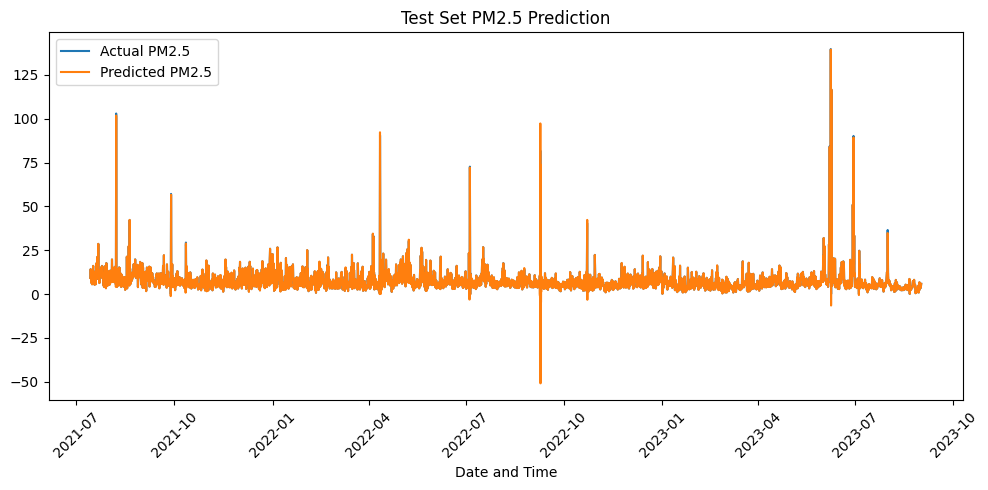

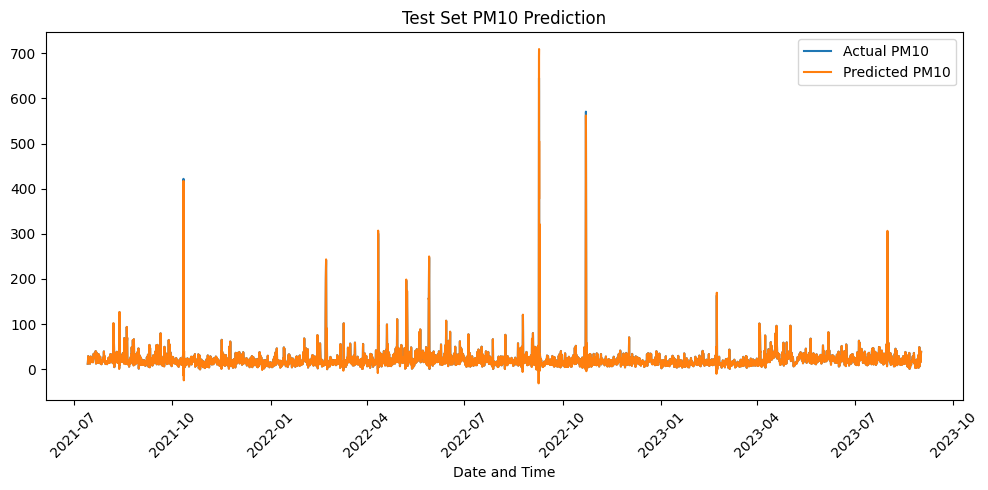

Test Metrics: {'RMSE': 0.00822044, 'MSE': 6.757563e-05, 'MAE': 0.00082393293, 'MAPE': inf}


C:\Users\User\AppData\Local\Temp\ipykernel_1480\487871382.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation


In [10]:
"US Dataset Training"
data = pd.read_csv(r"C:\Users\User\Code\databook\data\US\CombinedData\USCleanedPMData.csv", parse_dates=['DateTime'])
#weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US1_weights.pth'

#Sort the data
data.sort_values('DateTime', inplace=True)
date_times = data['DateTime'].reset_index(drop=True)
data = data.drop(columns=['DateTime'])

# Filtering and clipping
cutoff = 0.1
fs = 1.0
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #clip data to ensure it matches real PM data values

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for training and evaluation
EVEN_SPLIT = 0.5    #The data is evenly split between the validation and test 20% each


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)

# Split the sequences into training, validation, and test sets
x_train, x_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT,
    random_state=42,
    shuffle=False
)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=EVEN_SPLIT,
    random_state=42,
    shuffle=False
)

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
#model_weights_path = weights_file 

#model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Test Metrics:", metrics)

In [11]:
#Save the US model training weights
torch.save(model.state_dict(), r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2weights.pth')

cuda
Training on cuda
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 0.0000
Epoch 24, Validation Loss: 0.0000
Epoch 25, Validation Loss: 0.0000
Epoch 26, Validation Loss: 0.0000
Epoch 27, Validation Loss: 0.0000
Epoch 28, Validation Loss: 0.0000
Epoch 29, Validation Loss: 0.0000
E

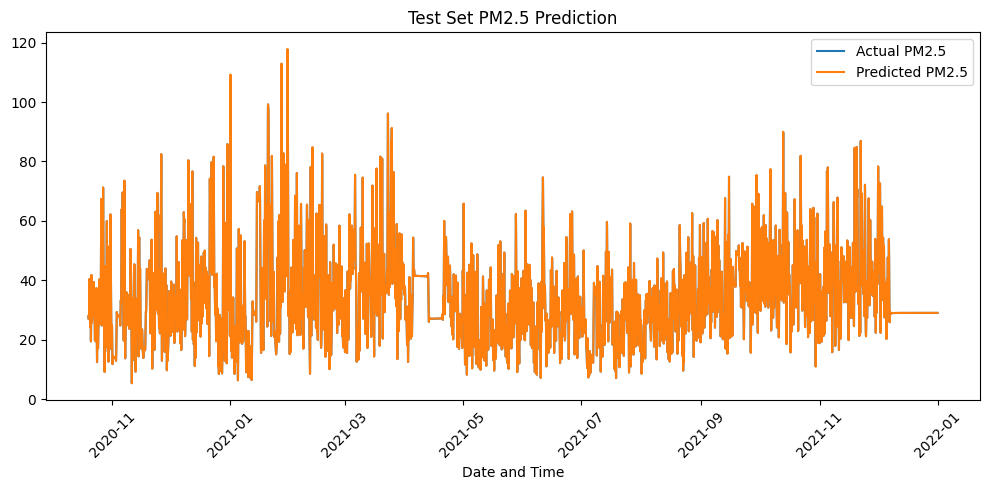

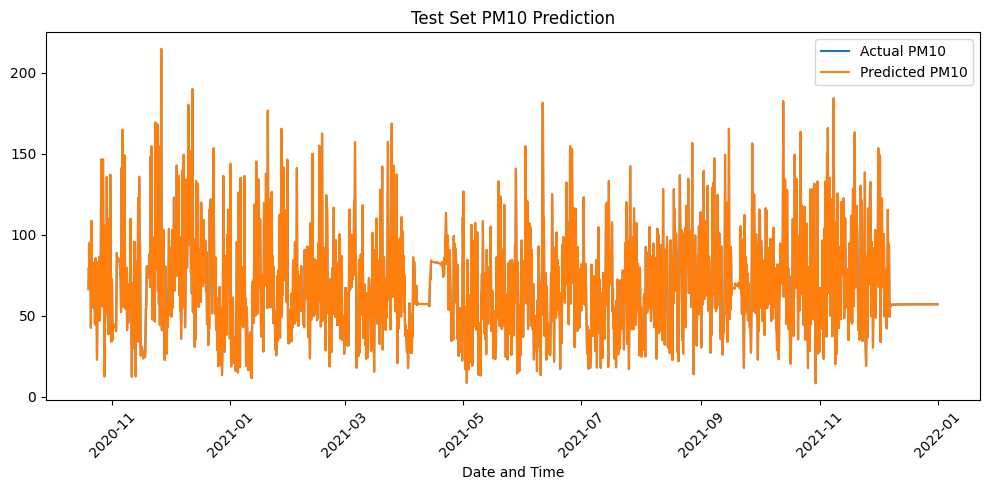

Test Metrics: {'RMSE': 0.00039269676, 'MSE': 1.5421075e-07, 'MAE': 0.00032779953, 'MAPE': 0.14263511402532458}


In [12]:
"Columbia Dataset Training"
data = pd.read_csv(r"C:\Users\User\Code\databook\data\Columbia\AllData\ColumbiaCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2weights.pth'

#Sort the data
data.sort_values('DateTime', inplace=True)
date_times = data['DateTime'].reset_index(drop=True)
data = data.drop(columns=['DateTime'])

# Filtering and clipping
cutoff = 0.1
fs = 1.0
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #clip data to ensure it matches real PM data values

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for training and evaluation
EVEN_SPLIT = 0.5    #The data is evenly split between the validation and test 20% each


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)

# Split the sequences into training, validation, and test sets
x_train, x_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT,
    random_state=42,
    shuffle=False
)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=EVEN_SPLIT,
    random_state=42,
    shuffle=False
)

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Test Metrics:", metrics)

In [13]:
#Save the model training weights
torch.save(model.state_dict(), r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col_weights.pth')

cuda
Training on cuda
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 0.0000
Epoch 24, Validation Loss: 0.0000
Epoch 25, Validation Loss: 0.0000
Epoch 26, Validation Loss: 0.0000
Epoch 27, Validation Loss: 0.0000
Epoch 28, Validation Loss: 0.0000
Epoch 29, Validation Loss: 0.0000
E

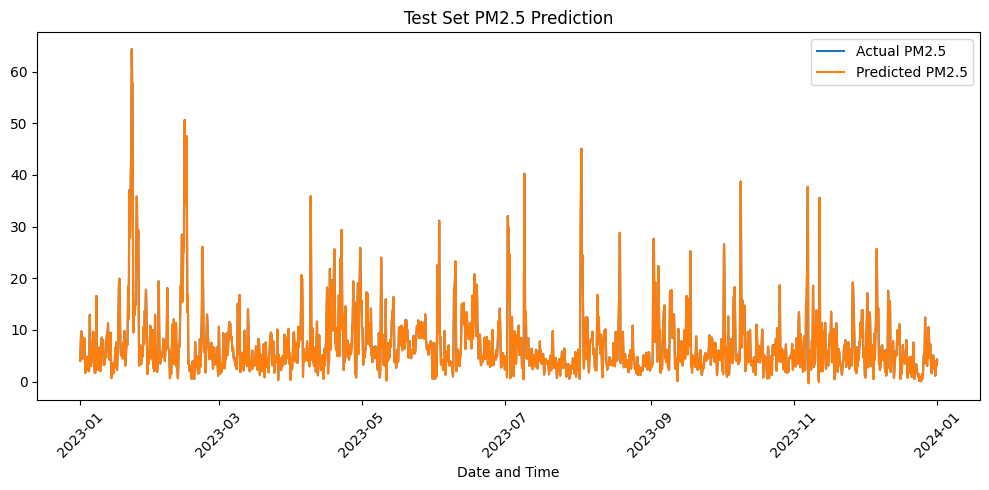

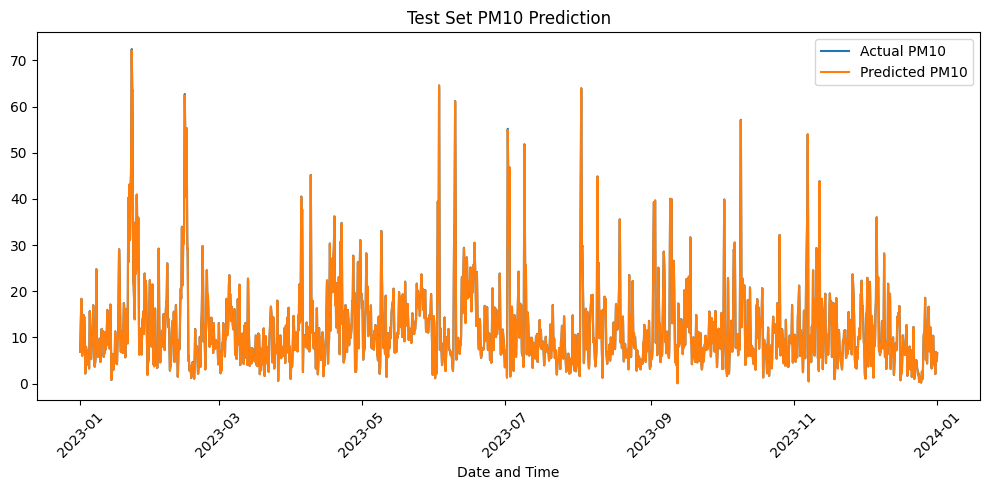

Test Metrics: {'RMSE': 0.0004958697, 'MSE': 2.458868e-07, 'MAE': 0.00040761096, 'MAPE': inf}


C:\Users\User\AppData\Local\Temp\ipykernel_1480\487871382.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation


In [14]:
data = pd.read_csv(r"C:\Users\User\Code\databook\data\UK\AllData\UKCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col_weights.pth'

#Sort the data
data.sort_values('DateTime', inplace=True)
date_times = data['DateTime'].reset_index(drop=True)
data = data.drop(columns=['DateTime'])

# Filtering and clipping
cutoff = 0.1
fs = 1.0
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #clip data to ensure it matches real PM data values

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for training and evaluation
EVEN_SPLIT = 0.5    #The data is evenly split between the validation and test 20% each


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)

# Split the sequences into training, validation, and test sets
x_train, x_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT,
    random_state=42,
    shuffle=False
)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=EVEN_SPLIT,
    random_state=42,
    shuffle=False
)

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Test Metrics:", metrics)

In [15]:
#Save the model training weights
torch.save(model.state_dict(), r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK_weights.pth')

cuda
Training on cuda
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 0.0000
Epoch 24, Validation Loss: 0.0000
Epoch 25, Validation Loss: 0.0000
Epoch 26, Validation Loss: 0.0000
Epoch 27, Validation Loss: 0.0000
Epoch 28, Validation Loss: 0.0000
Epoch 29, Validation Loss: 0.0000
E

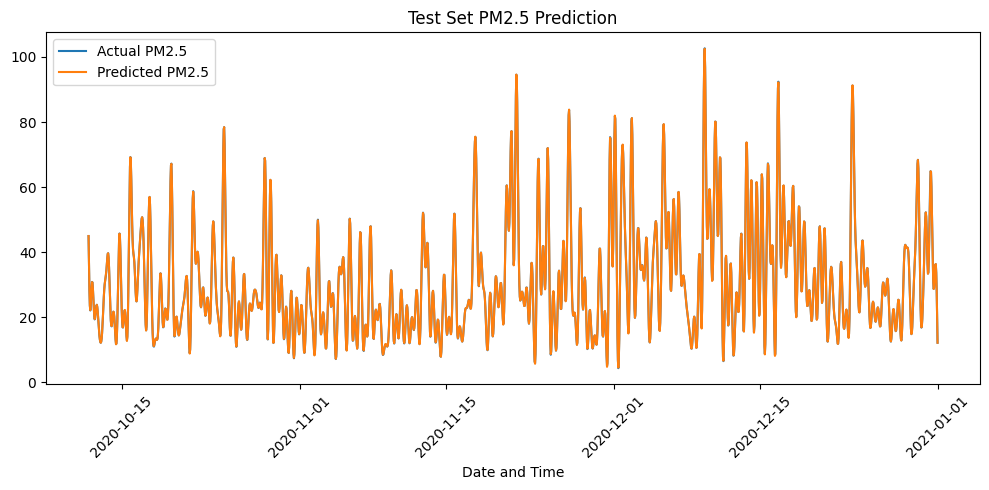

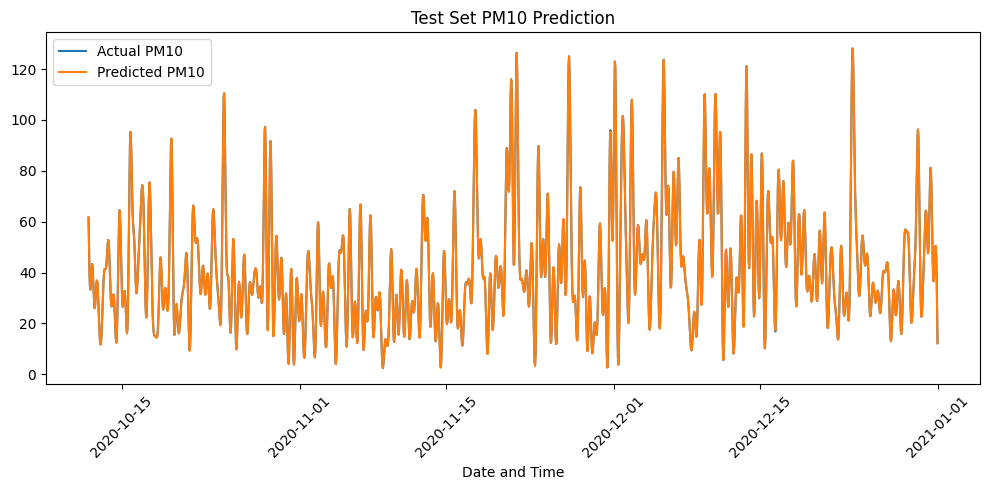

Test Metrics: {'RMSE': 0.0004934029, 'MSE': 2.4344638e-07, 'MAE': 0.0003426178, 'MAPE': 0.2694521564990282}


In [16]:
"Africa Dataset Training"
data = pd.read_csv(r"C:\Users\User\Code\databook\data\Africa\AfricaCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK_weights.pth'

#Sort the data
data.sort_values('DateTime', inplace=True)
date_times = data['DateTime'].reset_index(drop=True)
data = data.drop(columns=['DateTime'])

# Filtering and clipping
cutoff = 0.1
fs = 1.0
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #clip data to ensure it matches real PM data values

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for training and evaluation
EVEN_SPLIT = 0.5    #The data is evenly split between the validation and test 20% each


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)

# Split the sequences into training, validation, and test sets
x_train, x_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT,
    random_state=42,
    shuffle=False
)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=EVEN_SPLIT,
    random_state=42,
    shuffle=False
)

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Test Metrics:", metrics)

In [17]:
#Save the model training weights
torch.save(model.state_dict(), r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af_weights.pth')

cuda
Training on cuda
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 0.0000
Epoch 24, Validation Loss: 0.0000
Epoch 25, Validation Loss: 0.0000
Epoch 26, Validation Loss: 0.0000
Epoch 27, Validation Loss: 0.0000
Epoch 28, Validation Loss: 0.0000
Epoch 29, Validation Loss: 0.0000
E

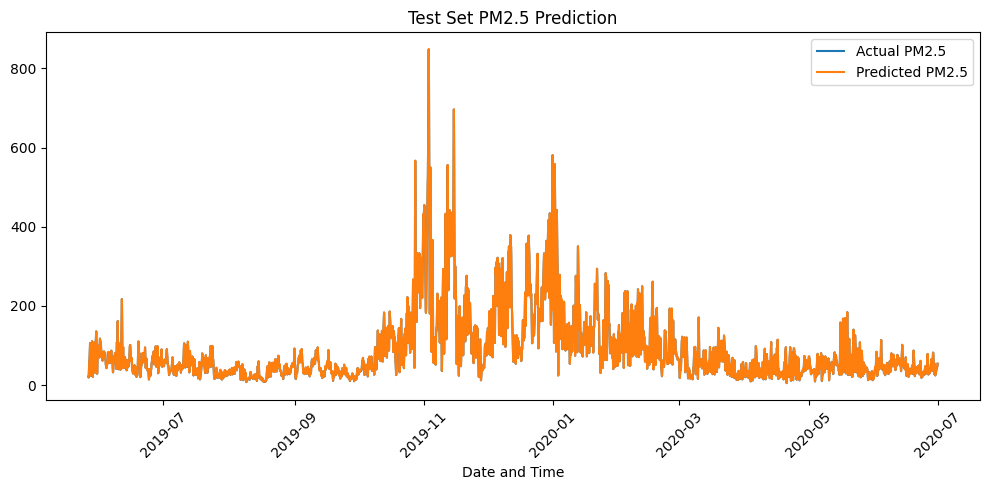

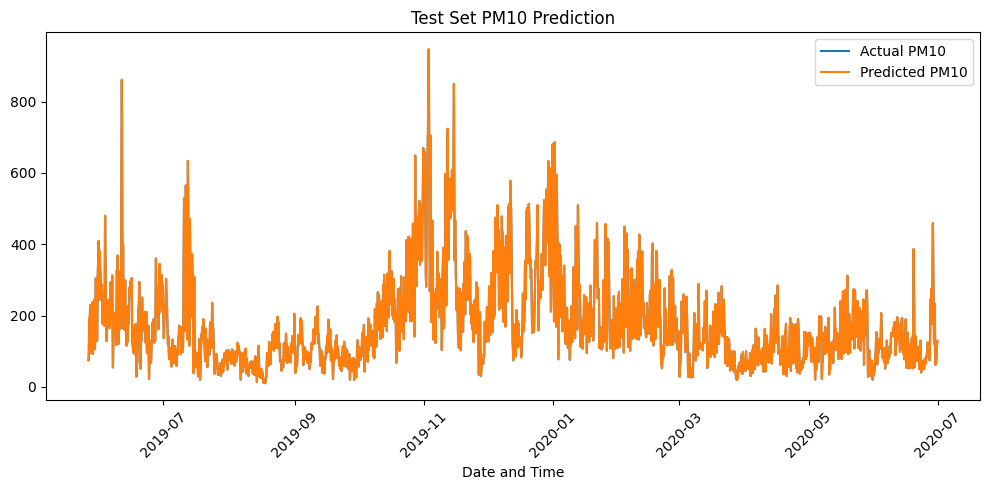

Test Metrics: {'RMSE': 0.000286883, 'MSE': 8.230186e-08, 'MAE': 0.00024816254, 'MAPE': 0.3918247763067484}


In [18]:
"India Dataset Training"
data = pd.read_csv(r"C:\Users\User\Code\databook\data\India\IndiaCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af_weights.pth'

#Sort the data
data.sort_values('DateTime', inplace=True)
date_times = data['DateTime'].reset_index(drop=True)
data = data.drop(columns=['DateTime'])

# Filtering and clipping
cutoff = 0.1
fs = 1.0
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #clip data to ensure it matches real PM data values

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for training and evaluation
EVEN_SPLIT = 0.5    #The data is evenly split between the validation and test 20% each


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)

# Split the sequences into training, validation, and test sets
x_train, x_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT,
    random_state=42,
    shuffle=False
)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=EVEN_SPLIT,
    random_state=42,
    shuffle=False
)

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Test Metrics:", metrics)

In [19]:
#Save the model training weights
torch.save(model.state_dict(), r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In_weights.pth')

cuda
Training on cuda
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 0.0000
Epoch 24, Validation Loss: 0.0000
Epoch 25, Validation Loss: 0.0000
Epoch 26, Validation Loss: 0.0000
Epoch 27, Validation Loss: 0.0000
Epoch 28, Validation Loss: 0.0000
Epoch 29, Validation Loss: 0.0000
E

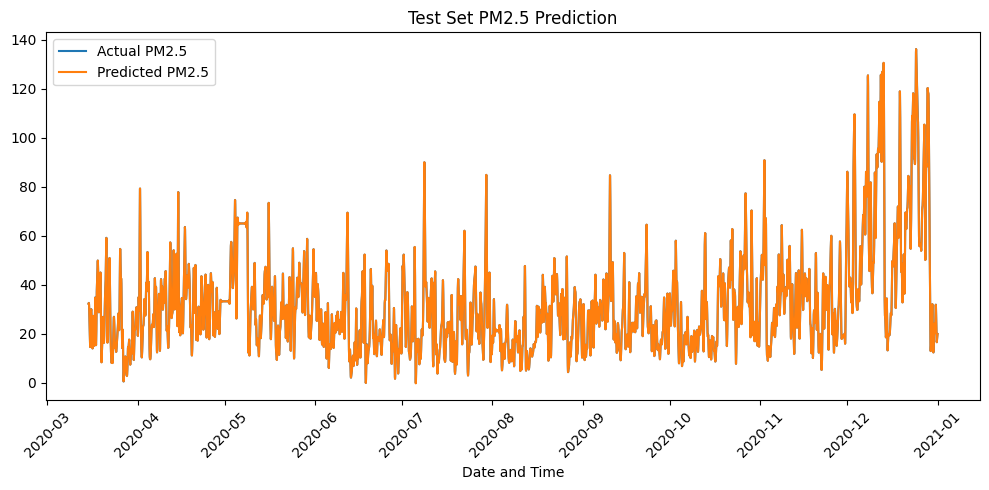

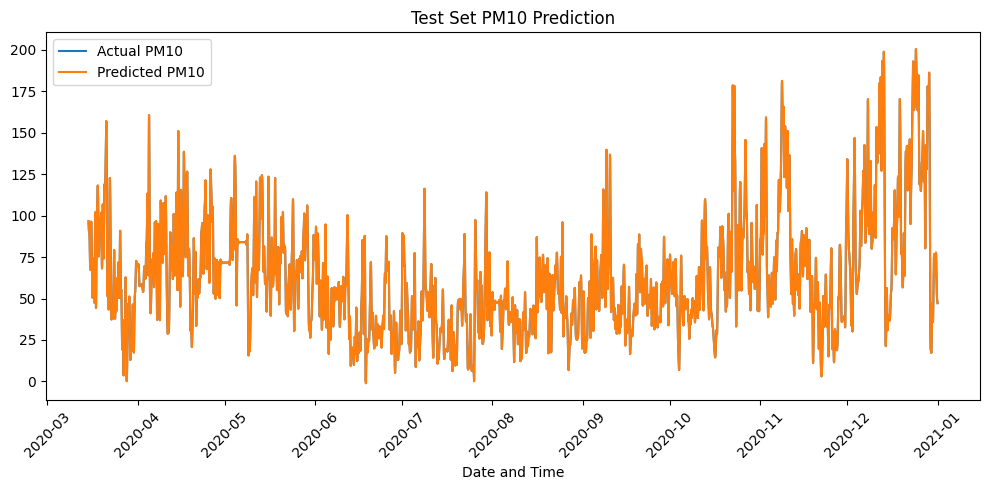

Test Metrics: {'RMSE': 0.00020315414, 'MSE': 4.12716e-08, 'MAE': 9.529603e-05, 'MAPE': inf}


C:\Users\User\AppData\Local\Temp\ipykernel_1480\487871382.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation


In [20]:
"China Dataset Training"
data = pd.read_csv(r"C:\Users\User\Code\databook\data\China\ChinaCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In_weights.pth'

#Sort the data
data.sort_values('DateTime', inplace=True)
date_times = data['DateTime'].reset_index(drop=True)
data = data.drop(columns=['DateTime'])

# Filtering and clipping
cutoff = 0.1
fs = 1.0
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #clip data to ensure it matches real PM data values

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for training and evaluation
EVEN_SPLIT = 0.5    #The data is evenly split between the validation and test 20% each


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)

# Split the sequences into training, validation, and test sets
x_train, x_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT,
    random_state=42,
    shuffle=False
)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=EVEN_SPLIT,
    random_state=42,
    shuffle=False
)

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Test Metrics:", metrics)

In [21]:
#Save the model training weights
torch.save(model.state_dict(), r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch_weights.pth')

cuda
Training on cuda
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 0.0000
Epoch 24, Validation Loss: 0.0000
Epoch 25, Validation Loss: 0.0000
Epoch 26, Validation Loss: 0.0000
Epoch 27, Validation Loss: 0.0000
Epoch 28, Validation Loss: 0.0000
Epoch 29, Validation Loss: 0.0000
E

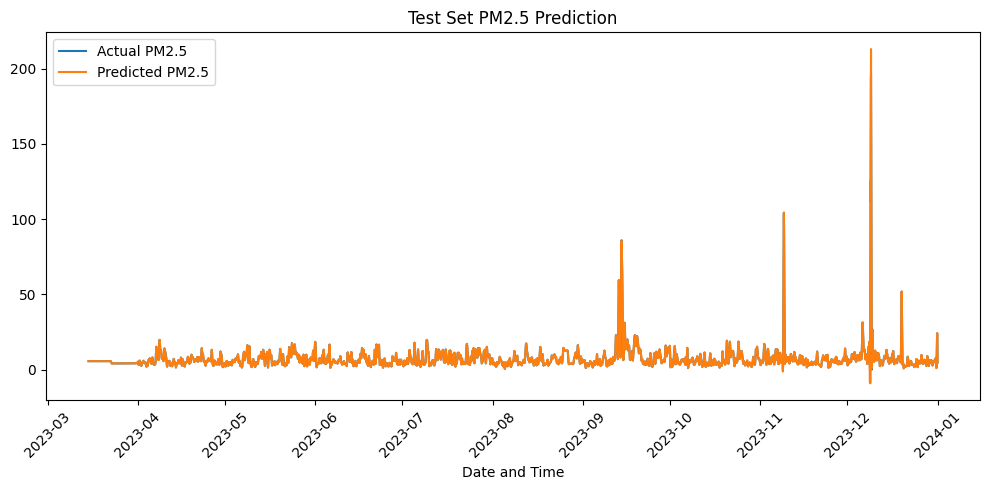

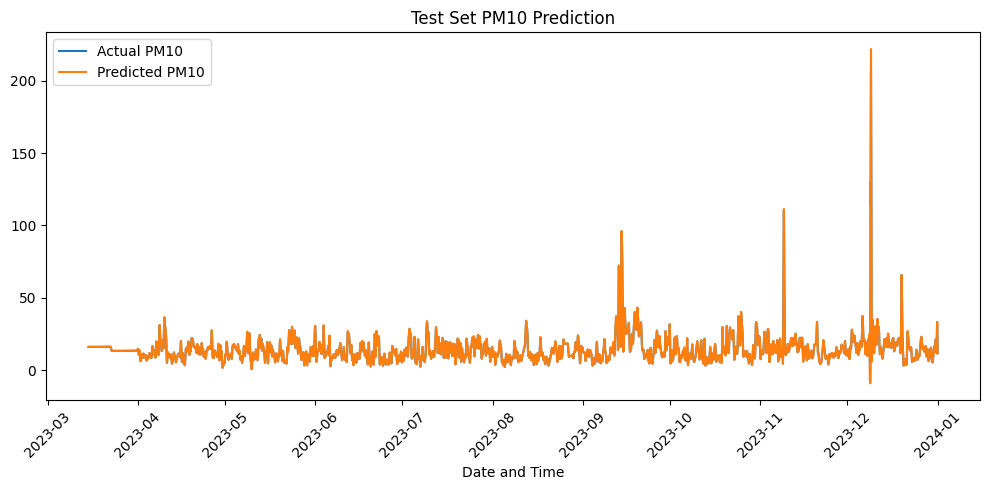

Test Metrics: {'RMSE': 0.0034370327, 'MSE': 1.1813194e-05, 'MAE': 0.00025512313, 'MAPE': inf}


C:\Users\User\AppData\Local\Temp\ipykernel_1480\487871382.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation


In [22]:
"Australia Dataset Training"
data = pd.read_csv(r"C:\Users\User\Code\databook\data\Australia\AllData\AustraliaCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch_weights.pth'

#Sort the data
data.sort_values('DateTime', inplace=True)
date_times = data['DateTime'].reset_index(drop=True)
data = data.drop(columns=['DateTime'])

# Filtering and clipping
cutoff = 0.1
fs = 1.0
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)
data[['PM2.5_filtered', 'PM10_filtered']] = data[['PM2.5_filtered', 'PM10_filtered']].clip(lower=0) #clip data to ensure it matches real PM data values

#Set data split percentages
TRAIN_SIZE = 0.6    #60% for training
TEST_VALIDATION_SPLIT = 0.4  #%40 for training and evaluation
EVEN_SPLIT = 0.5    #The data is evenly split between the validation and test 20% each


# Fit scaler only on the training portion of the dataset
train_index = int(len(data) * TRAIN_SIZE)
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_index])

# Apply scaler to training data
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create seqeunces
seq_length = 24
x, y, dates = create_sequences(data, seq_length, date_times)

# Split the sequences into training, validation, and test sets
x_train, x_temp, y_train, y_temp, dates_train, dates_temp = train_test_split(
    x, y, dates,
    test_size=TEST_VALIDATION_SPLIT,
    random_state=42,
    shuffle=False
)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices]

x_val, x_test, y_val, y_test, dates_val, dates_test = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=EVEN_SPLIT,
    random_state=42,
    shuffle=False
)

#Use GPU for tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Test Metrics:", metrics)

In [23]:
#Save the model training weights
torch.save(model.state_dict(), r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch+Au_weights.pth')

TL Model
Data Split Percetage: 94.5205% used for testing
Test Dataset Size = 24839 hours =  1034.9583333333333 days = 34.49861111111111 months (approx.)
Training and Validation Dataset Size = 1441 hours =  60.041666666666664 days = 2.001388888888889 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22

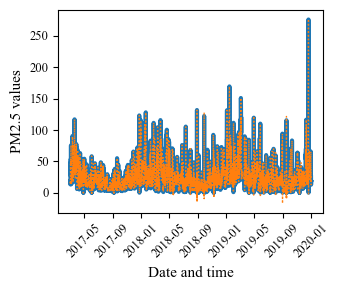

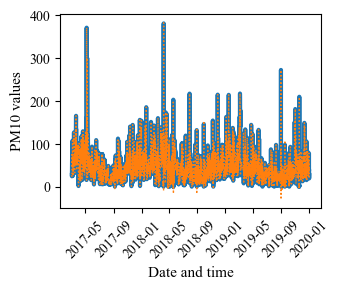

TL Model Test Metrics: {'RMSE': 0.005463058, 'MSE': 2.9845003e-05, 'MAE': 0.000592693, 'MAPE': 5.04048578441143}


In [16]:
"Transfer Learning Trained Model Test - Korea"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Korea\KoreaCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch+Au_weights.pth'


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 5.4795/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print("TL Model")
print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 


#Use CPU
device = torch.device("cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
tl_test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'




print("TL PM2.5 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 0], linewidth=3 )          #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, tl_test_predictions[:, 0], linestyle=':', linewidth=1 )   #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.xlabel('Date and time', fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM2.5 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(c)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM2.5_{TEST_SIZE*100}%_v2_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
'''

print("TL PM10 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 1], linewidth=3)        #Old code: plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, tl_test_predictions[:, 1], linestyle=':', linewidth=1)        #Old code: plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and time',  fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM10 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(d)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM10_{TEST_SIZE*100}%_v2_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

'''

plt.show()
#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("TL Model Test Metrics:", metrics)

Data Split Percetage: 94.5205% used for testing
Test Dataset Size = 24839 hours =  1034.9583333333333 days = 34.49861111111111 months (approx.)
Training and Validation Dataset Size = 1441 hours =  60.041666666666664 days = 2.001388888888889 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0056
Epoch 2, Validation Loss: 0.0024
Epoch 3, Validation Loss: 0.0031
Epoch 4, Validation Loss: 0.0014
Epoch 5, Validation Loss: 0.0009
Epoch 6, Validation Loss: 0.0006
Epoch 7, Validation Loss: 0.0005
Epoch 8, Validation Loss: 0.0005
Epoch 9, Validation Loss: 0.0003
Epoch 10, Validation Loss: 0.0003
Epoch 11, Validation Loss: 0.0002
Epoch 12, Validation Loss: 0.0002
Epoch 13, Validation Loss: 0.0002
Epoch 14, Validation Loss: 0.0001
Epoch 15, Validation Loss: 0.0001
Epoch 16, Validation Loss: 0.0001
Epoch 17, Validation Loss: 0.0001
Epoch 18, Validation Loss: 0.0001
Epoch 19, Validation Loss: 0.0001
Epoch 20, Validation Loss: 0.0001
Epoch 21, Validation Loss: 0.0001
Epoch 22, Validat

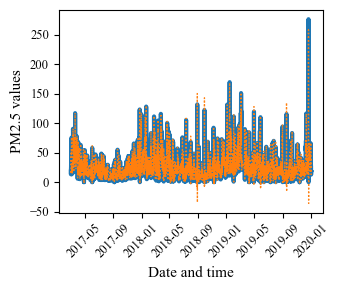

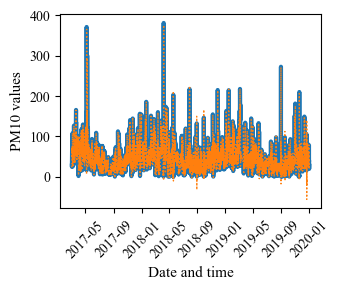

Base Model Test Metrics: {'RMSE': 0.01104961, 'MSE': 0.00012209387, 'MAE': 0.0050550625, 'MAPE': 43.86683404445648}


In [18]:
"Base LSTM Model Test - Korea"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Korea\KoreaCleanedPMData.csv", parse_dates=['DateTime'])


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 5.4795/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 

#Use GPU for tensors
device = torch.device("cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)



#Check if GPU is available and set the device
device = torch.device('cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
base_test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'




print("Base PM2.5 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 0], linewidth=3 )          #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, base_test_predictions[:, 0], linestyle=':', linewidth=1 )   #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.xlabel('Date and time', fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM2.5 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(c)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM2.5_{TEST_SIZE*100}%_v2_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
'''

print("Base PM10 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 1], linewidth=3)        #Old code: plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, base_test_predictions[:, 1], linestyle=':', linewidth=1)        #Old code: plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and time',  fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM10 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(d)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM10_{TEST_SIZE*100}%_v2_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


'''
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Base Model Test Metrics:", metrics)

In [19]:
#Save results

# Get the current time
current_time = datetime.datetime.now().time()
TIME = current_time.strftime("%H-%M-%S")

# Convert your results and dates into a DataFrame
results_df = pd.DataFrame({
    'Date': dates_test,
    'Actual_PM2.5': test_targets[:, 0],
    'Base Model Predicted_PM2.5': base_test_predictions[:, 0],
    'TL Model Predicted_PM2.5': tl_test_predictions[:, 0],
    'Actual_PM10': test_targets[:, 1],
    'Base Model Predicted_PM10': base_test_predictions[:, 1],
    'TL Model Predicted_PM10': tl_test_predictions[:, 1]
})

# Save the DataFrame to a CSV file
results_path = f"C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/Model_Res/Model_Results_{TRAIN_SIZE*100}%_{TIME}.csv"
results_df.to_csv(results_path, index=False)
print(f"Saved to: {results_path}")

Saved to: C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/Model_Res/Model_Results_5.4795%_15-34-10.csv


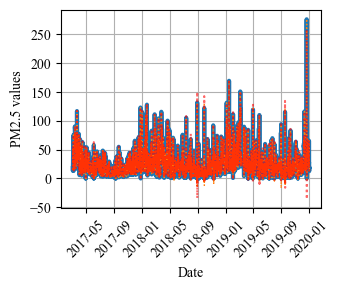

<Figure size 350x300 with 0 Axes>

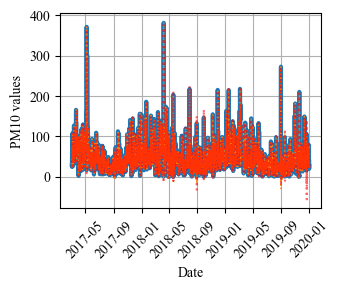

In [20]:
"Combined Prediction graphs"
#Plot PM2.5 graphs
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, test_targets[:, 0], linestyle='-', label='PM2.5 Actual Values', alpha=1, linewidth=3)
plt.plot(dates_test, tl_test_predictions[:, 0], linestyle=':', label='PM2.5 TL Model' , alpha=1, linewidth=1)
plt.plot(dates_test, base_test_predictions[:, 0], color='red', linestyle=':', linewidth=1.5, label='PM2.5 Base Model' , alpha=0.6)

plt.xlabel('Date')
plt.ylabel('PM2.5 values')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/Pred_Graphs/Korea_PM2.5_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

#Plot PM10 graphs
plt.figure(figsize=(3.5, 3))

plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, test_targets[:, 1], linestyle='-', label='PM10 Actual Values', alpha=1, linewidth=3)
plt.plot(dates_test, tl_test_predictions[:, 1], linestyle=':', label='PM10 TL Model' , alpha=1, linewidth=1)
plt.plot(dates_test, base_test_predictions[:, 1], color='red', linestyle=':', linewidth=1.5, label='PM10 Base Model' , alpha=0.6)

plt.xlabel('Date')
plt.ylabel('PM10 values')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/Pred_Graphs/Korea_PM10_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

plt.show()


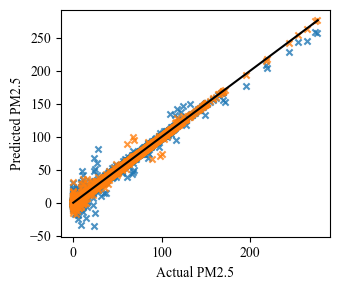

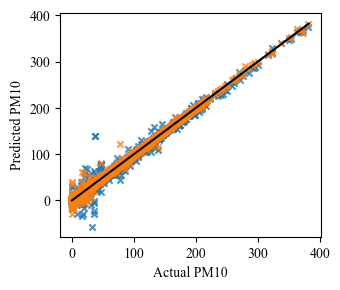

In [21]:
"Scatter Plots"

dates_test = np.array(dates_test)  # Date information
actual_pm25 = test_targets[:, 0]
base_predicted_pm25 = base_test_predictions[:, 0]
tl_predicted_pm25 = tl_test_predictions[:, 0]
actual_pm10 = test_targets[:, 1]
base_predicted_pm10 = base_test_predictions[:, 1]
tl_predicted_pm10 = tl_test_predictions[:, 1]

markersize = 20 #set markersize

# Create a figure and axis objects
# PM2.5 Scatter Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(actual_pm25, base_predicted_pm25,  label='Base Model Predicted PM2.5', alpha=0.8, marker='x', s=markersize)
ax.scatter(actual_pm25, tl_predicted_pm25,  label='TL Model Predicted PM2.5', alpha=0.8, marker='x', s=markersize)
# Ideal line
max_value_pm25 = max(actual_pm25.max(), base_predicted_pm25.max(), tl_predicted_pm25.max())
ax.plot([0, max_value_pm25], [0, max_value_pm25], 'k-', label='Ideal 1:1 Line')
ax.set_xlabel('Actual PM2.5')
ax.set_ylabel('Predicted PM2.5')
#ax.legend()
#ax.set_title('Actual vs. Predicted PM2.5')
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/ScatPlot/SP_Korea_Korea_PM2.5_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


# PM10 Scatter Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(actual_pm10, base_predicted_pm10, label='Base Model Predicted PM10', alpha=0.8, marker='x', s=markersize)
ax.scatter(actual_pm10, tl_predicted_pm10, label='TL Model Predicted PM10', alpha=0.8, marker='x', s=markersize)
# Ideal line
max_value_pm10 = max(actual_pm10.max(), base_predicted_pm10.max(), tl_predicted_pm10.max())
ax.plot([0, max_value_pm10], [0, max_value_pm10], 'k-', label='Ideal 1:1 Line')
ax.set_xlabel('Actual PM10')
ax.set_ylabel('Predicted PM10')
#ax.legend()
#ax.set_title('Actual vs. Predicted PM10')
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/ScatPlot/SP_Korea_PM10_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
plt.show()

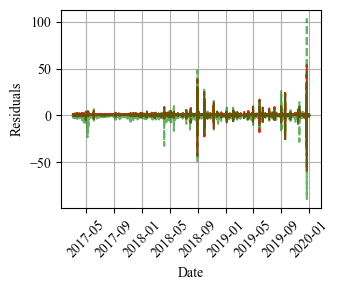

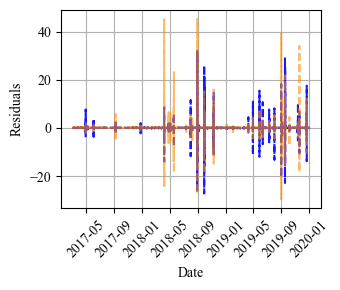

In [22]:
"Combined residual graphs"
# Calculate residuals
base_residuals_pm2_5 = base_test_predictions[:, 0] - test_targets[:, 0]
base_residuals_pm10 = base_test_predictions[:, 1] - test_targets[:, 1]

tl_residuals_pm2_5 = tl_test_predictions[:, 0] - test_targets[:, 0]
tl_residuals_pm10 = tl_test_predictions[:, 1] - test_targets[:, 1]


#Plot Base graph
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, base_residuals_pm2_5, color='red', linestyle='--', label='PM2.5 Base Model' , alpha=0.9)
plt.plot(dates_test, base_residuals_pm10, color='green', linestyle='--', label='PM10 Base Model', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Residuals')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

#Save graph
path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/ResidualPlots/RP_Korea_BaseModel_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


#Plot PM10 graph
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, tl_residuals_pm2_5, color='blue',  linestyle='--', label='PM2.5 TL Model' , alpha=0.9)
plt.plot(dates_test, tl_residuals_pm10, color='darkorange',  linestyle='--', label='PM10 TL Model', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Residuals')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

#Save graph
path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/ResidualPlots/RP_Korea_TLModel_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


plt.show()

Data Split Percetage: 96.9743% used for testing
Test Dataset Size = 46152 hours =  1923.0 days = 64.1 months (approx.)
Training and Validation Dataset Size = 1440 hours =  60.0 days = 2.0 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0001
Epoch 2, Validation Loss: 0.0004
Epoch 3, Validation Loss: 0.0002
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0002
Epoch 6, Validation Loss: 0.0001
Epoch 7, Validation Loss: 0.0001
Epoch 8, Validation Loss: 0.0003
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0001
Epoch 11, Validation Loss: 0.0001
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0002
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0001
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 0.0000
Ep

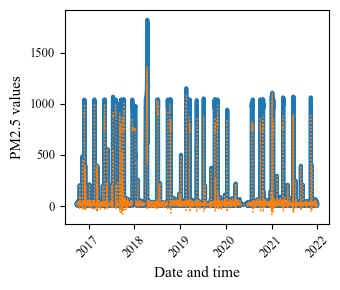

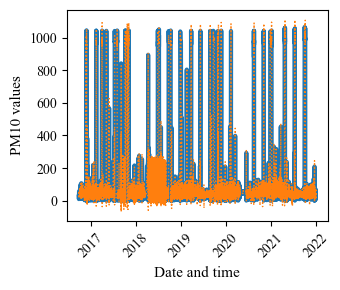

Base Model Test Metrics: {'RMSE': 0.034600586, 'MSE': 0.0011972006, 'MAE': 0.01007723, 'MAPE': inf}


C:\Users\User\AppData\Local\Temp\ipykernel_3048\487871382.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation


In [196]:
"Base LSTM Model Test - Mexico"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Mexico\MexicoCleanedPMData.csv", parse_dates=['DateTime'])


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 3.0257/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 

#Use GPU for tensors
device = torch.device("cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)



#Check if GPU is available and set the device
device = torch.device('cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
base_test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'




print("Base PM2.5 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 0], linewidth=3 )          #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, base_test_predictions[:, 0], linestyle=':', linewidth=1 )   #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.xlabel('Date and time', fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM2.5 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(c)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM2.5_{TEST_SIZE*100}%_v2_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
'''

print("Base PM10 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 1], linewidth=3)        #Old code: plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, base_test_predictions[:, 1], linestyle=':', linewidth=1)        #Old code: plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and time',  fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM10 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(d)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM10_{TEST_SIZE*100}%_v2_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


'''
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Base Model Test Metrics:", metrics)

TL Model
Data Split Percetage: 96.9743% used for testing
Test Dataset Size = 46152 hours =  1923.0 days = 64.1 months (approx.)
Training and Validation Dataset Size = 1440 hours =  60.0 days = 2.0 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Loss: 

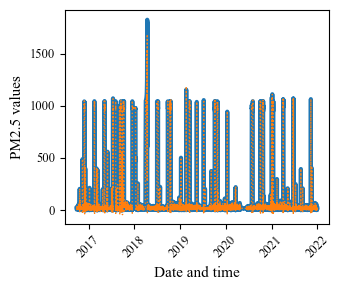

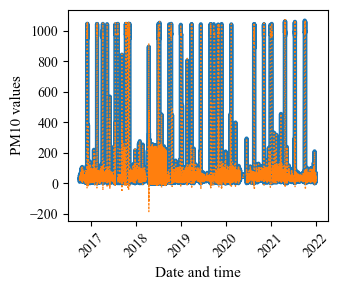

TL Model Test Metrics: {'RMSE': 0.010601467, 'MSE': 0.00011239112, 'MAE': 0.0025083292, 'MAPE': inf}


C:\Users\User\AppData\Local\Temp\ipykernel_3048\487871382.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation


In [194]:
"Transfer Learning Trained Model Test - Mexico"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Mexico\MexicoCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch+Au_weights.pth'


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 3.0257/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print("TL Model")
print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 


#Use CPU
device = torch.device("cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
tl_test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'




print("TL PM2.5 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 0], linewidth=3 )          #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, tl_test_predictions[:, 0], linestyle=':', linewidth=1 )   #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.xlabel('Date and time', fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM2.5 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(c)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM2.5_{TEST_SIZE*100}%_v2_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
'''

print("TL PM10 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 1], linewidth=3)        #Old code: plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, tl_test_predictions[:, 1], linestyle=':', linewidth=1)        #Old code: plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and time',  fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM10 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(d)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM10_{TEST_SIZE*100}%_v2_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

'''

plt.show()
#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("TL Model Test Metrics:", metrics)

In [197]:
#Save results

# Get the current time
current_time = datetime.datetime.now().time()
TIME = current_time.strftime("%H-%M-%S")

# Convert your results and dates into a DataFrame
results_df = pd.DataFrame({
    'Date': dates_test,
    'Actual_PM2.5': test_targets[:, 0],
    'Base Model Predicted_PM2.5': base_test_predictions[:, 0],
    'TL Model Predicted_PM2.5': tl_test_predictions[:, 0],
    'Actual_PM10': test_targets[:, 1],
    'Base Model Predicted_PM10': base_test_predictions[:, 1],
    'TL Model Predicted_PM10': tl_test_predictions[:, 1]
})

# Save the DataFrame to a CSV file
results_path = f"C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Mexico/Model_Res/Mexico_Model_Results_{TRAIN_SIZE*100}%_{TIME}.csv"
results_df.to_csv(results_path, index=False)
print(f"Saved to: {results_path}")

Saved to: C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Mexico/Model_Res/Mexico_Model_Results_3.0257%_17-55-50.csv


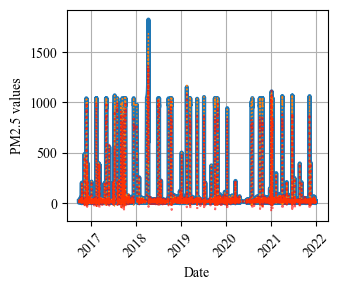

<Figure size 350x300 with 0 Axes>

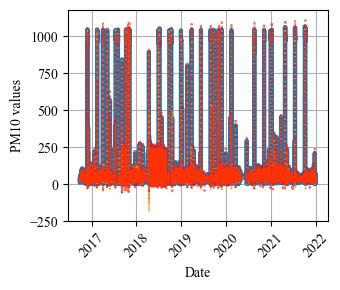

In [198]:
"Combined Prediction graphs"
#Plot PM2.5 graphs
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, test_targets[:, 0], linestyle='-', label='PM2.5 Actual Values', alpha=1, linewidth=3)
plt.plot(dates_test, tl_test_predictions[:, 0], linestyle=':', label='PM2.5 TL Model' , alpha=1, linewidth=1)
plt.plot(dates_test, base_test_predictions[:, 0], color='red', linestyle=':', linewidth=1.5, label='PM2.5 Base Model' , alpha=0.6)

plt.xlabel('Date')
plt.ylabel('PM2.5 values')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Mexico/Pred_Graphs/Mexico_PM2.5_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

#Plot PM10 graphs
plt.figure(figsize=(3.5, 3))

plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, test_targets[:, 1], linestyle='-', label='PM10 Actual Values', alpha=1, linewidth=3)
plt.plot(dates_test, tl_test_predictions[:, 1], linestyle=':', label='PM10 TL Model' , alpha=1, linewidth=1)
plt.plot(dates_test, base_test_predictions[:, 1], color='red', linestyle=':', linewidth=1.5, label='PM10 Base Model' , alpha=0.6)

plt.xlabel('Date')
plt.ylabel('PM10 values')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Mexico/Pred_Graphs/Mexico_PM10_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

plt.show()


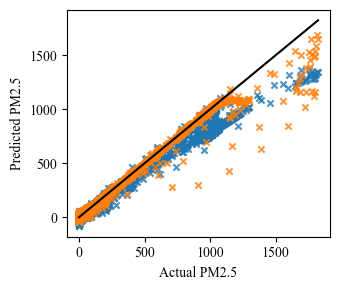

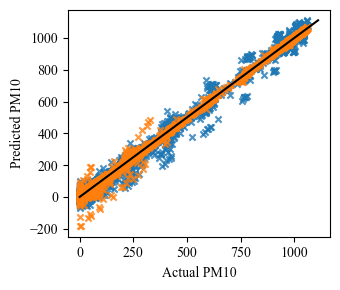

In [199]:
"Scatter Plots"

dates_test = np.array(dates_test)  # Date information
actual_pm25 = test_targets[:, 0]
base_predicted_pm25 = base_test_predictions[:, 0]
tl_predicted_pm25 = tl_test_predictions[:, 0]
actual_pm10 = test_targets[:, 1]
base_predicted_pm10 = base_test_predictions[:, 1]
tl_predicted_pm10 = tl_test_predictions[:, 1]

markersize = 20 #set markersize

# Create a figure and axis objects
# PM2.5 Scatter Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(actual_pm25, base_predicted_pm25,  label='Base Model Predicted PM2.5', alpha=0.8, marker='x', s=markersize)
ax.scatter(actual_pm25, tl_predicted_pm25,  label='TL Model Predicted PM2.5', alpha=0.8, marker='x', s=markersize)
# Ideal line
max_value_pm25 = max(actual_pm25.max(), base_predicted_pm25.max(), tl_predicted_pm25.max())
ax.plot([0, max_value_pm25], [0, max_value_pm25], 'k-', label='Ideal 1:1 Line')
ax.set_xlabel('Actual PM2.5')
ax.set_ylabel('Predicted PM2.5')
#ax.legend()
#ax.set_title('Actual vs. Predicted PM2.5')
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Mexico/ScatPlot/SP_Mexico_PM2.5_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


# PM10 Scatter Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(actual_pm10, base_predicted_pm10, label='Base Model Predicted PM10', alpha=0.8, marker='x', s=markersize)
ax.scatter(actual_pm10, tl_predicted_pm10, label='TL Model Predicted PM10', alpha=0.8, marker='x', s=markersize)
# Ideal line
max_value_pm10 = max(actual_pm10.max(), base_predicted_pm10.max(), tl_predicted_pm10.max())
ax.plot([0, max_value_pm10], [0, max_value_pm10], 'k-', label='Ideal 1:1 Line')
ax.set_xlabel('Actual PM10')
ax.set_ylabel('Predicted PM10')
#ax.legend()
#ax.set_title('Actual vs. Predicted PM10')
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/ScatPlot/SP_Mexico_PM10_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
plt.show()

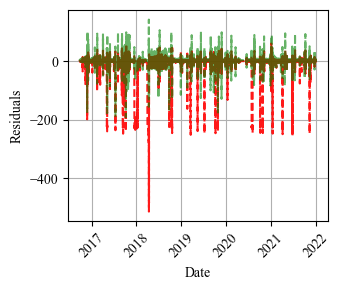

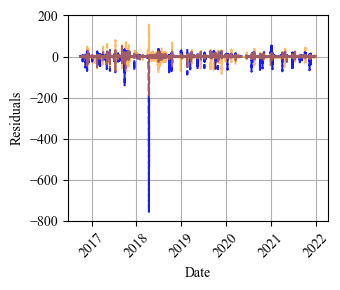

In [200]:
"Combined residual graphs"
# Calculate residuals
base_residuals_pm2_5 = base_test_predictions[:, 0] - test_targets[:, 0]
base_residuals_pm10 = base_test_predictions[:, 1] - test_targets[:, 1]

tl_residuals_pm2_5 = tl_test_predictions[:, 0] - test_targets[:, 0]
tl_residuals_pm10 = tl_test_predictions[:, 1] - test_targets[:, 1]


#Plot Base graph
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, base_residuals_pm2_5, color='red', linestyle='--', label='PM2.5 Base Model' , alpha=0.9)
plt.plot(dates_test, base_residuals_pm10, color='green', linestyle='--', label='PM10 Base Model', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Residuals')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

#Save graph
path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Mexico/ResidualPlots/RP_Mexico_BaseModel_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


#Plot PM10 graph
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, tl_residuals_pm2_5, color='blue',  linestyle='--', label='PM2.5 TL Model' , alpha=0.9)
plt.plot(dates_test, tl_residuals_pm10, color='darkorange',  linestyle='--', label='PM10 TL Model', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Residuals')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

#Save graph
path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Mexico/ResidualPlots/RP_Mexico_TLModel_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


plt.show()

Data Split Percetage: 96.4803% used for testing
Test Dataset Size = 59208 hours =  2467.0 days = 82.23333333333333 months (approx.)
Training and Validation Dataset Size = 2160 hours =  90.0 days = 3.0 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0056
Epoch 2, Validation Loss: 0.0024
Epoch 3, Validation Loss: 0.0013
Epoch 4, Validation Loss: 0.0010
Epoch 5, Validation Loss: 0.0008
Epoch 6, Validation Loss: 0.0005
Epoch 7, Validation Loss: 0.0004
Epoch 8, Validation Loss: 0.0004
Epoch 9, Validation Loss: 0.0003
Epoch 10, Validation Loss: 0.0003
Epoch 11, Validation Loss: 0.0002
Epoch 12, Validation Loss: 0.0002
Epoch 13, Validation Loss: 0.0002
Epoch 14, Validation Loss: 0.0001
Epoch 15, Validation Loss: 0.0001
Epoch 16, Validation Loss: 0.0002
Epoch 17, Validation Loss: 0.0002
Epoch 18, Validation Loss: 0.0002
Epoch 19, Validation Loss: 0.0001
Epoch 20, Validation Loss: 0.0001
Epoch 21, Validation Loss: 0.0001
Epoch 22, Validation Loss: 0.0001
Epoch 23, Validation Lo

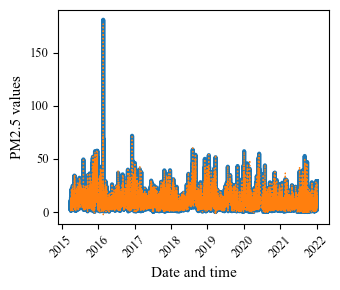

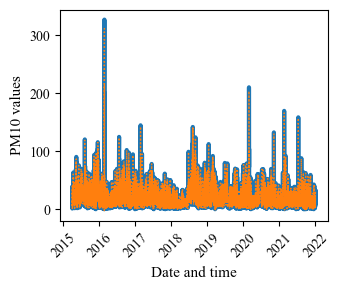

Base Model Test Metrics: {'RMSE': 0.0066022943, 'MSE': 4.359029e-05, 'MAE': 0.0035384009, 'MAPE': 3.1668536365032196}


In [185]:
"Base LSTM Model Test - Spain"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Spain\SpainCleanedPMData.csv", parse_dates=['DateTime'])


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 3.5197/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 

#Use GPU for tensors
device = torch.device("cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)



#Check if GPU is available and set the device
device = torch.device('cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
base_test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'




print("Base PM2.5 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 0], linewidth=3 )          #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, base_test_predictions[:, 0], linestyle=':', linewidth=1 )   #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.xlabel('Date and time', fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM2.5 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(c)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM2.5_{TEST_SIZE*100}%_v2_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
'''

print("Base PM10 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 1], linewidth=3)        #Old code: plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, base_test_predictions[:, 1], linestyle=':', linewidth=1)        #Old code: plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and time',  fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM10 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(d)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM10_{TEST_SIZE*100}%_v2_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


'''
plt.show()

#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("Base Model Test Metrics:", metrics)

TL Model
Data Split Percetage: 96.4803% used for testing
Test Dataset Size = 59208 hours =  2467.0 days = 82.23333333333333 months (approx.)
Training and Validation Dataset Size = 2160 hours =  90.0 days = 3.0 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Vali

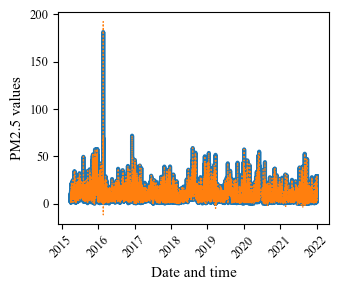

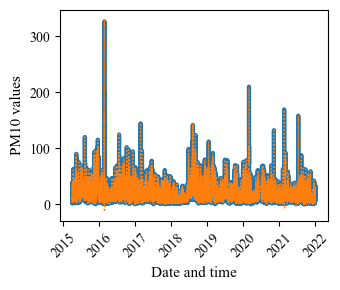

TL Model Test Metrics: {'RMSE': 0.005886389, 'MSE': 3.4649573e-05, 'MAE': 0.00035589456, 'MAPE': 0.6766359321773052}


In [192]:
"Transfer Learning Trained Model Test - Spain"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Spain\SpainCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch+Au_weights.pth'


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 3.5197/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print("TL Model")
print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 


#Use CPU
device = torch.device("cpu")
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cpu')
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    # Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
tl_test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime

# Set the default font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'




print("TL PM2.5 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 0], linewidth=3 )          #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, tl_test_predictions[:, 0], linestyle=':', linewidth=1 )   #old code: plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.xlabel('Date and time', fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM2.5 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(c)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM2.5_{TEST_SIZE*100}%_v2_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
'''

print("TL PM10 Graph")
print(f'Data Scarcity % = {TEST_SIZE*100}%')
plt.figure(figsize=(3.5,3))
plt.plot(dates_test, test_targets[:, 1], linewidth=3)        #Old code: plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, tl_test_predictions[:, 1], linestyle=':', linewidth=1)        #Old code: plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and time',  fontsize=11 , fontname='Times New Roman')
plt.ylabel('PM10 values',  fontsize=11 , fontname='Times New Roman')
#plt.legend()
#plt.title('(d)', fontdict={'fontsize': 12, 'fontname': 'Times New Roman'})
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

'''
path = f'C:/Users/User/Lab/Global Air Pollution/Results/OptRes/Korea/Korea_Base_PM10_{TEST_SIZE*100}%_v2_{TIME}'
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

'''

plt.show()
#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print("TL Model Test Metrics:", metrics)

In [186]:
#Save results

# Get the current time
current_time = datetime.datetime.now().time()
TIME = current_time.strftime("%H-%M-%S")

# Convert your results and dates into a DataFrame
results_df = pd.DataFrame({
    'Date': dates_test,
    'Actual_PM2.5': test_targets[:, 0],
    'Base Model Predicted_PM2.5': base_test_predictions[:, 0],
    'TL Model Predicted_PM2.5': tl_test_predictions[:, 0],
    'Actual_PM10': test_targets[:, 1],
    'Base Model Predicted_PM10': base_test_predictions[:, 1],
    'TL Model Predicted_PM10': tl_test_predictions[:, 1]
})

# Save the DataFrame to a CSV file
results_path = f"C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Spain/Model_Res/Spain_Model_Results_{TRAIN_SIZE*100}%_{TIME}.csv"
results_df.to_csv(results_path, index=False)
print(f"Saved to: {results_path}")

Saved to: C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Spain/Model_Res/Spain_Model_Results_3.5197%_17-38-09.csv


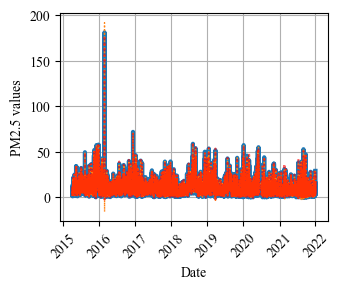

<Figure size 350x300 with 0 Axes>

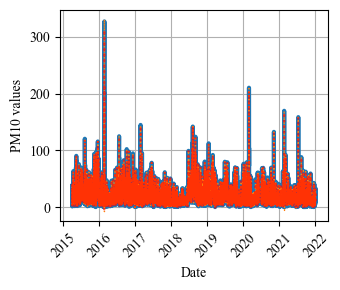

In [187]:
"Combined Prediction graphs"
#Plot PM2.5 graphs
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, test_targets[:, 0], linestyle='-', label='PM2.5 Actual Values', alpha=1, linewidth=3)
plt.plot(dates_test, tl_test_predictions[:, 0], linestyle=':', label='PM2.5 TL Model' , alpha=1, linewidth=1)
plt.plot(dates_test, base_test_predictions[:, 0], color='red', linestyle=':', linewidth=1.5, label='PM2.5 Base Model' , alpha=0.6)

plt.xlabel('Date')
plt.ylabel('PM2.5 values')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Spain/Pred_Graphs/Spain_PM2.5_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

#Plot PM10 graphs
plt.figure(figsize=(3.5, 3))

plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, test_targets[:, 1], linestyle='-', label='PM10 Actual Values', alpha=1, linewidth=3)
plt.plot(dates_test, tl_test_predictions[:, 1], linestyle=':', label='PM10 TL Model' , alpha=1, linewidth=1)
plt.plot(dates_test, base_test_predictions[:, 1], color='red', linestyle=':', linewidth=1.5, label='PM10 Base Model' , alpha=0.6)

plt.xlabel('Date')
plt.ylabel('PM10 values')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Spain/Pred_Graphs/Spain_PM10_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 

plt.show()


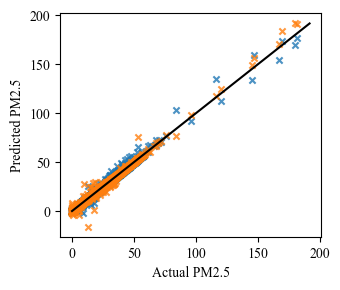

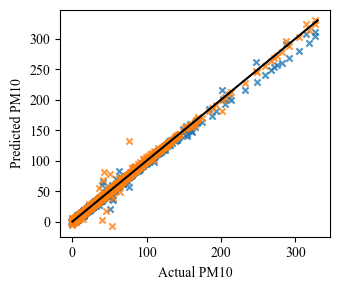

In [188]:
"Scatter Plots"

dates_test = np.array(dates_test)  # Date information
actual_pm25 = test_targets[:, 0]
base_predicted_pm25 = base_test_predictions[:, 0]
tl_predicted_pm25 = tl_test_predictions[:, 0]
actual_pm10 = test_targets[:, 1]
base_predicted_pm10 = base_test_predictions[:, 1]
tl_predicted_pm10 = tl_test_predictions[:, 1]

markersize = 20 #set markersize

# Create a figure and axis objects
# PM2.5 Scatter Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(actual_pm25, base_predicted_pm25,  label='Base Model Predicted PM2.5', alpha=0.8, marker='x', s=markersize)
ax.scatter(actual_pm25, tl_predicted_pm25,  label='TL Model Predicted PM2.5', alpha=0.8, marker='x', s=markersize)
# Ideal line
max_value_pm25 = max(actual_pm25.max(), base_predicted_pm25.max(), tl_predicted_pm25.max())
ax.plot([0, max_value_pm25], [0, max_value_pm25], 'k-', label='Ideal 1:1 Line')
ax.set_xlabel('Actual PM2.5')
ax.set_ylabel('Predicted PM2.5')
#ax.legend()
#ax.set_title('Actual vs. Predicted PM2.5')
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Spain/ScatPlot/SP_Spain_PM2.5_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


# PM10 Scatter Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.scatter(actual_pm10, base_predicted_pm10, label='Base Model Predicted PM10', alpha=0.8, marker='x', s=markersize)
ax.scatter(actual_pm10, tl_predicted_pm10, label='TL Model Predicted PM10', alpha=0.8, marker='x', s=markersize)
# Ideal line
max_value_pm10 = max(actual_pm10.max(), base_predicted_pm10.max(), tl_predicted_pm10.max())
ax.plot([0, max_value_pm10], [0, max_value_pm10], 'k-', label='Ideal 1:1 Line')
ax.set_xlabel('Actual PM10')
ax.set_ylabel('Predicted PM10')
#ax.legend()
#ax.set_title('Actual vs. Predicted PM10')
plt.tight_layout()

path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Korea/ScatPlot/SP_Spain_PM10_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 
plt.show()

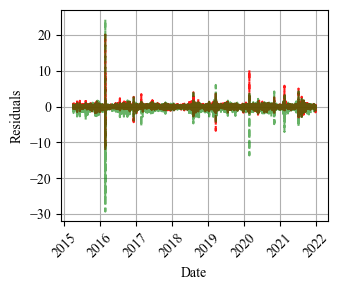

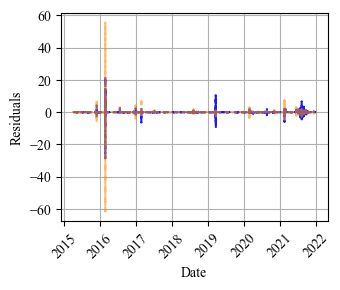

In [189]:
"Combined residual graphs"
# Calculate residuals
base_residuals_pm2_5 = base_test_predictions[:, 0] - test_targets[:, 0]
base_residuals_pm10 = base_test_predictions[:, 1] - test_targets[:, 1]

tl_residuals_pm2_5 = tl_test_predictions[:, 0] - test_targets[:, 0]
tl_residuals_pm10 = tl_test_predictions[:, 1] - test_targets[:, 1]


#Plot Base graph
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, base_residuals_pm2_5, color='red', linestyle='--', label='PM2.5 Base Model' , alpha=0.9)
plt.plot(dates_test, base_residuals_pm10, color='green', linestyle='--', label='PM10 Base Model', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Residuals')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

#Save graph
path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Spain/ResidualPlots/RP_Spain_BaseModel_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


#Plot PM10 graph
plt.figure(figsize=(3.5, 3))
plt.plot(dates_test, tl_residuals_pm2_5, color='blue',  linestyle='--', label='PM2.5 TL Model' , alpha=0.9)
plt.plot(dates_test, tl_residuals_pm10, color='darkorange',  linestyle='--', label='PM10 TL Model', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Residuals')
#plt.title('Residual Plot of PM Predictions')
#plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

#Save graph
path = f'C:/Users/User/Lab/Global Air Pollution/Results/PureLSTM/Spain/ResidualPlots/RP_Spain_TLModel_{TRAIN_SIZE*100}%_{TIME}' 
plt.savefig(path +'.png', dpi=300)  # PNG format 
plt.savefig(path + '.jpg', dpi=300)  # JPEG format 
plt.savefig(path + '.svg' , dpi=300)  # SVG format,
plt.savefig(path + '.tiff', dpi=300)  # tiff format 


plt.show()

In [215]:
"Transfer Learning Trained Model Test - Individual Models - Korea"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Korea\KoreaCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch_weights.pth'


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 0.3196/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 

#Use GPU for tensors
device = torch.device("cpu")  #Old code "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cpu') #Old code:'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')


# Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime
'''
plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], linestyle='--', label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''


#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print(weights_file)
    print(f"Data Percentage: {TRAIN_SIZE*100}%")
    print("Test Metrics:", metrics)

Data Split Percetage: 99.6804% used for testing
Test Dataset Size = 26196 hours =  1091.5 days = 36.38333333333333 months (approx.)
Training and Validation Dataset Size = 84 hours =  3.5 days = 0.11666666666666667 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, 

In [227]:
"Transfer Learning Trained Model Test - Individual Models - Mexico"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Mexico\MexicoCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch_weights.pth'


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 4.5386/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 

#Use GPU for tensors
device = torch.device("cpu")  #Old code "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cpu') #Old code:'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')


# Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime
'''
plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], linestyle='--', label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''


#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print(weights_file)
    print(f"Data Percentage: {TRAIN_SIZE*100}%")
    print("Test Metrics:", metrics)

Data Split Percetage: 95.4614% used for testing
Test Dataset Size = 45431 hours =  1892.9583333333333 days = 63.09861111111111 months (approx.)
Training and Validation Dataset Size = 2161 hours =  90.04166666666667 days = 3.001388888888889 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validati

C:\Users\User\AppData\Local\Temp\ipykernel_3048\487871382.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE calculation


In [243]:
"Transfer Learning Trained Model Test - Individual Models - Spain"

data = pd.read_csv(r"C:\Users\User\Code\databook\data\Spain\SpainCleanedPMData.csv", parse_dates=['DateTime'])
weights_file = r'C:\Users\User\Code\databook\PureLSTMWeights\PureLSTM_model_US2+Col+UK+Af+In+Ch_weights.pth'


data.sort_values('DateTime', inplace=True)  # Ensure data is sorted by DateTime

# Separate DateTime for use in alignment later
date_times = data['DateTime'].reset_index(drop=True)

# Drop the DateTime column from the dataset to prepare data for the model
data = data.drop(columns=['DateTime'])

# Apply Butterworth filter
cutoff = 0.1  # Desired cutoff frequency of the filter, Hz
fs = 1.0  # Sample rate, Hz
data['PM2.5_filtered'] = butter_lowpass_filter(data['PM2.5'], cutoff, fs)
data['PM10_filtered'] = butter_lowpass_filter(data['PM10'], cutoff, fs)

# Clip negative values to zero (since pollution can't be negative)
data['PM2.5_filtered'] = data['PM2.5_filtered'].clip(lower=0)
data['PM10_filtered'] = data['PM10_filtered'].clip(lower=0)

#Set data splitting percentages
TRAIN_SIZE = 3.5197/100       #Percentage of dataset used for training
TEST_SIZE = 1 - TRAIN_SIZE         #Percentage of dataset used for testing
VALIDATION_SIZE = 0.2   #Percentage of remaining data used for validation

test_data_size = int(TEST_SIZE * len(data["PM2.5_filtered"]))
train_val_size = len(data["PM2.5_filtered"]) - test_data_size
train_val_index = train_val_size  # Index where test data starts

print(f"Data Split Percetage: {TEST_SIZE*100}% used for testing")
print(f"Test Dataset Size = {test_data_size} hours =  {test_data_size/24} days = {test_data_size/(24*30)} months (approx.)")
print(f"Training and Validation Dataset Size = {train_val_size} hours =  {train_val_size/24} days = {train_val_size/(24*30)} months (approx.)")

# Fit data only on training and validation subsets of the data
scaler = MinMaxScaler()
scaler.fit(data[['PM2.5_filtered', 'PM10_filtered']].iloc[:train_val_index])  

# Apply scaling to the full dataset
data[['PM2.5_filtered', 'PM10_filtered']] = scaler.transform(data[['PM2.5_filtered', 'PM10_filtered']])

# Create sequences once, after scaling
seq_length = 24  # 24 hours - 1 day
x, y, dates = create_sequences(data, seq_length, date_times)

# Perform splitting on sequences
x_temp, x_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    x, y, dates,
    test_size=TEST_SIZE, 
    random_state=42,
    shuffle=False
)

x_train, x_val, y_train, y_val, dates_train, dates_val = train_test_split(
    x_temp, y_temp, dates_temp,
    test_size=VALIDATION_SIZE, 
    random_state=42,
    shuffle=False
)

# Shuffle the training set to enhance model generalization by randomly shuffling the indicies of the split datasets
indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
dates_train = dates_train[indices] 

#Use GPU for tensors
device = torch.device("cpu")  #Old code "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Convert to PyTorch tensors and move them to the correct device
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Used to create batches from a dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize the model
model = PureLSTM(input_size=2, hidden_size=opt_hs, num_layers=opt_nl, output_size=2)

# Load pre-trained weights into the model
model_weights_path = weights_file 

model.load_state_dict(torch.load(model_weights_path))

#Check if GPU is available and set the device
device = torch.device('cpu') #Old code:'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Training on {device}')

# Move the model to the chosen device
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)  #Set the optimizer  
criterion = nn.MSELoss() #Set the loss function

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')


# Plotting results
# Assuming you want to see the prediction results on the test set:
test_predictions = []
test_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        # Move x_batch to the same device as the model
        x_batch = x_batch.to(device)
        y_pred = model(x_batch).cpu()  # Ensure predictions are moved back to CPU
        
        # Move predictions and targets back to CPU and convert to numpy
        test_predictions.append(y_pred.cpu().numpy())
        test_targets.append(y_batch.cpu().numpy())

# Convert lists of arrays into single arrays
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Inverse transform predictions back to original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

# Use the dates_test for plotting
dates_test = [pd.to_datetime(date) for date in dates_test]  # Convert to datetime
'''
plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 0], label='Actual PM2.5')
plt.plot(dates_test, test_predictions[:, 0], linestyle='--', label='Predicted PM2.5')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM2.5 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(dates_test, test_targets[:, 1], label='Actual PM10')
plt.plot(dates_test, test_predictions[:, 1], linestyle='--', label='Predicted PM10')
plt.xlabel('Date and Time')
plt.legend()
plt.title('Test Set PM10 Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''


#Forward pass through the model on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    # Convert and move tensors to the same device as the model
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)  
    y_test_true = torch.tensor(y_test, dtype=torch.float32).to(device)  
    
    # Forward pass
    y_test_pred = model(x_test_tensor)

    # Ensure to move predictions and targets to CPU if needed before calculating metrics
    y_test_pred = y_test_pred.cpu()
    y_test_true = y_test_true.cpu()

    # Calculate metrics
    metrics = calculate_metrics(y_test_true, y_test_pred)
    print(weights_file)
    print(f"Data Percentage: {TRAIN_SIZE*100}%")
    print("Test Metrics:", metrics)

Data Split Percetage: 96.4803% used for testing
Test Dataset Size = 59208 hours =  2467.0 days = 82.23333333333333 months (approx.)
Training and Validation Dataset Size = 2160 hours =  90.0 days = 3.0 months (approx.)
cpu
Training on cpu
Epoch 1, Validation Loss: 0.0000
Epoch 2, Validation Loss: 0.0000
Epoch 3, Validation Loss: 0.0000
Epoch 4, Validation Loss: 0.0000
Epoch 5, Validation Loss: 0.0000
Epoch 6, Validation Loss: 0.0000
Epoch 7, Validation Loss: 0.0000
Epoch 8, Validation Loss: 0.0000
Epoch 9, Validation Loss: 0.0000
Epoch 10, Validation Loss: 0.0000
Epoch 11, Validation Loss: 0.0000
Epoch 12, Validation Loss: 0.0000
Epoch 13, Validation Loss: 0.0000
Epoch 14, Validation Loss: 0.0000
Epoch 15, Validation Loss: 0.0000
Epoch 16, Validation Loss: 0.0000
Epoch 17, Validation Loss: 0.0000
Epoch 18, Validation Loss: 0.0000
Epoch 19, Validation Loss: 0.0000
Epoch 20, Validation Loss: 0.0000
Epoch 21, Validation Loss: 0.0000
Epoch 22, Validation Loss: 0.0000
Epoch 23, Validation Lo